### THIS FILE
is used only for prototyping. That means, testing, training and comparing will be done only in python files .py. We write code here check for errors and copy it to python files for modularity.

jupyter notebooks could be for parts where I need to experiment and interact with code (not for part with automation)


Example structure of ML projects:

```
/my-ml-project/
├── data/               # Raw, processed, and interim datasets (optional gitignore)
├── notebooks/          # Jupyter notebooks for exploration (optional)
├── src/                # Source code
│   ├── __init__.py
│   ├── data/           # Data loading, transformation, augmentation
│   ├── models/         # Model architectures
│   ├── training/       # Training pipelines, schedulers
│   ├── evaluation/     # Metrics, evaluation scripts
│   ├── utils/          # Helper utilities, common functions
│   ├── serving/        # (Optional) Model inference logic
│   ├── cli.py          # CLI entrypoint (e.g., train.py)
│   └── config.yaml     # Hyperparameters, paths
├── tests/              # Unit and integration tests
├── experiments/        # MLFlow experiment tracking, model comparison
├── deployment/         # Production code, Dockerfiles, API code
│   ├── app/            # FastAPI / Flask / gRPC app for model serving
│   ├── docker/         # Dockerfiles and entrypoints
│   ├── infrastructure/ # Helm charts, Terraform, CI/CD scripts
├── scripts/            # Bash, Python automation scripts (e.g., download_data.sh)
├── logs/               # Training logs, TensorBoard runs (gitignored)
├── .env                # Environment variables
├── requirements.txt / pyproject.toml
├── MLproject           # MLFlow entrypoint
├── outputs/           # Main folder for all generated artifacts
│   ├── checkpoints/   # Model state_dicts (e.g., .pth, .pt files)
│   ├── logs/          # TensorBoard logs, training logs
│   ├── predictions/   # Inference outputs (optional)
│   └── figures/       # Generated evaluation plots
└── README.md
```

ATTENTION!!!
In machine learning (especially neural networks), it is customary to refer to the sets involved in the training loop as training and validation sets. The test set is used on the trained model. Therefore, confusion may arise when in some tutorials (especially those derived from scikit-learn*) the validation set rarely appears, and when it does, its definition is confused with the test set. This is simply a naming convention, and as long as the general logic of model training is understood, it does not matter.

In this notebook, to avoid misunderstandings, I have retained the old naming convention where the test set participates in the training loop because the food101 set itself does not have a validation set. In the main part of the project, I solve this problem by combining the sets and redistributing them in the correct structure.

*Unlike scikit-learn, the validation set is not optional, because neural networks have much greater model capacity and a tendency to overfit. If we want to obtain a model that generalizes very well, the validation set is mandatory. Both deep learning frameworks and scikit-learn have a test set that serves the same purpose.

In [1]:
import os
import torch
import torch.nn as nn
import random
from PIL import Image
import glob  # allows, among other things, the use of wildcards in file names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms  # transforms allow you to represent a jpg image in the form of numbers.
from torchvision.transforms import Resize
from torchinfo import summary  # model information
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter  # create a folder ./runs/ where it will save the results for tensorboard. (remember to install the tensorboard package (conda or pip))
import os 
from pathlib import Path
import cv2
from collections import defaultdict
import onnx
import onnxruntime as ort

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
path_to_data = Path.cwd().parent / "Data/food-101_30%_tr70_va15_te15"

def walk_through_dirs(dir_path):
    for dir_name, subdir_list, file_list in os.walk(dir_path):  # HINT n the case of os.walk(), no matter what we name the next three variables, they always represent: root (current directory), dirs (subdirectories of the current directory), files (files present in the subdirectories)
                                                                # os.walk(dir_path, topdown=True) is the default parameter
        print(f"Found directory: {dir_name}")
        print(f"Subdirectories: {subdir_list}")
        print(f"Files: {file_list}")
        print("\n")

walk_through_dirs(path_to_data)

Found directory: /home/kamil-solski/Documents/Python/Projekty_py/Food101_MLOps-Lvl_1/Data/food-101_30%_tr70_va15_te15
Subdirectories: ['fold1', 'fold3', 'fold0', 'fold4', 'fold2']
Files: ['classes.txt']


Found directory: /home/kamil-solski/Documents/Python/Projekty_py/Food101_MLOps-Lvl_1/Data/food-101_30%_tr70_va15_te15/fold1
Subdirectories: ['test', 'val', 'train']
Files: []


Found directory: /home/kamil-solski/Documents/Python/Projekty_py/Food101_MLOps-Lvl_1/Data/food-101_30%_tr70_va15_te15/fold1/test
Subdirectories: ['apple_pie', 'beef_tartare', 'caesar_salad', 'cannoli']
Files: []


Found directory: /home/kamil-solski/Documents/Python/Projekty_py/Food101_MLOps-Lvl_1/Data/food-101_30%_tr70_va15_te15/fold1/test/apple_pie
Subdirectories: []
Files: ['936189.jpg', '858876.jpg', '3915901.jpg', '2673907.jpg', '3209538.jpg', '2200328.jpg', '1043283.jpg', '3506848.jpg', '3192077.jpg', '1072416.jpg', '265928.jpg', '1528623.jpg', '2856319.jpg', '1290425.jpg', '1200079.jpg', '2298862.jpg', '

In [9]:
path_to_runs = Path.cwd().parent / "outputs/runs/food-101_30%_tr70_va15_te15"
writer = SummaryWriter(path_to_runs)  # initializing functions and specifying the path to the log

In [10]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001

## Przygotowanie danych

### Pobieranie danych 
(ustawienie training i testing sets)

In [18]:
random.seed(42)

# image path do ścieżki pathlib
image_path = Path(path_to_data)

fold_dir = path_to_data / "fold0"
train_dir = fold_dir / "train"
test_dir  = fold_dir / "test"

# pobranie listy ścieżek wszystkich obrazków zarówno z train jak i test
image_path_list = list(fold_dir.rglob("*.jpg"))  # pierwsza * oznacza dowolną nazwę pierwszego folderu po food-101_10% (w tym przypadku train lub test). Ostatni * oznacza już downolną nazwę pliku

# losowanie jednego obrazka z listy scieżek
random_image_path = random.choice(image_path_list)

# pobranie nazwy klasy dla wylosowanego obrazka (odpowiadający jemu)
image_class = random_image_path.parent.stem

# otworzenie obrazka
img = Image.open(random_image_path)

print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7793B4630D30>


##### konwersja danych na tensory 
https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

**Data augmentation** - proces modyfikowania danych w taki sposób aby zwiększyć różnorodność danych a przez to ich jakość (więcej input features do nauczenia -> większa skuteczność modelu przy nowych danych). Jesteśmy to w stanie osiągnąć dzięki transforms. z transforms.Compose(), np. transforms.RandomHorizontalFlip().
W celu zapoznania się z innymi: https://pytorch.org/vision/stable/transforms.html

In [19]:
# określenie transformera
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # zmiana rozdzielczości obrazka (zmniejszenie rozdzielczości - szybsze uczenie)
    #transforms.RandomHorizontalFlip(p=0.5),  # jest 50% szans na odbicie obrazka w pionie (odbicie lustrzane)
    transforms.TrivialAugmentWide(num_magnitude_bins=15),  # bins od 0 do 31 która określa maksymalną intensywność agumentacji gdzie 31 oznacza np. zakres pełnego obrotu
    transforms.ToTensor()  # konwersja na właściwy format (z HxWxC na CxHxW)
])

Ponieważ dane znajdują się w odpowiednich katalogach możemy wykorzystać ImageFolder.
To jak działa ImageFolder obrazuje plik: /home/kamil-solski/Documents/Python/Projekty_py/Food-101/ImgFolder.ipynb

In [20]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

# uzyskiwanie klas z nazw folderów
class_names = train_data.classes
class_names

with open(path_to_data / "classes.txt", "w") as f:
    for name in train_data.classes:
        f.write(name + "\n")

In [21]:
# potwierdzenie poprawnego wczytania obrazka
imag, label = train_data[0][0], train_data[0][1]
print(imag.shape, label)
print(len(train_data), len(test_data))

torch.Size([3, 64, 64]) 0
960 120


### Wizualizacja danych
jakie były nasze dane przed przerobieniem

img i imag powinny mieć taką samą wymiarowość

In [22]:
print(data_transform(img))
print(data_transform(img).shape)  # widzimy że dane mają odpowiednią rozdzielczość

tensor([[[0.0706, 0.0706, 0.0745,  ..., 0.0431, 0.0353, 0.0314],
         [0.0706, 0.0706, 0.0706,  ..., 0.0392, 0.0353, 0.0314],
         [0.0667, 0.0706, 0.0706,  ..., 0.0431, 0.0353, 0.0314],
         ...,
         [0.0157, 0.0275, 0.0392,  ..., 0.0314, 0.0314, 0.0392],
         [0.0078, 0.0118, 0.0235,  ..., 0.0275, 0.0314, 0.0353],
         [0.0078, 0.0078, 0.0118,  ..., 0.0275, 0.0353, 0.0353]],

        [[0.0549, 0.0588, 0.0588,  ..., 0.0353, 0.0314, 0.0235],
         [0.0549, 0.0588, 0.0588,  ..., 0.0353, 0.0314, 0.0275],
         [0.0588, 0.0588, 0.0549,  ..., 0.0353, 0.0314, 0.0275],
         ...,
         [0.0078, 0.0196, 0.0314,  ..., 0.0275, 0.0235, 0.0314],
         [0.0078, 0.0078, 0.0157,  ..., 0.0196, 0.0275, 0.0314],
         [0.0078, 0.0039, 0.0078,  ..., 0.0196, 0.0275, 0.0275]],

        [[0.0353, 0.0392, 0.0392,  ..., 0.0235, 0.0196, 0.0196],
         [0.0353, 0.0353, 0.0314,  ..., 0.0275, 0.0196, 0.0196],
         [0.0353, 0.0353, 0.0314,  ..., 0.0275, 0.0235, 0.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

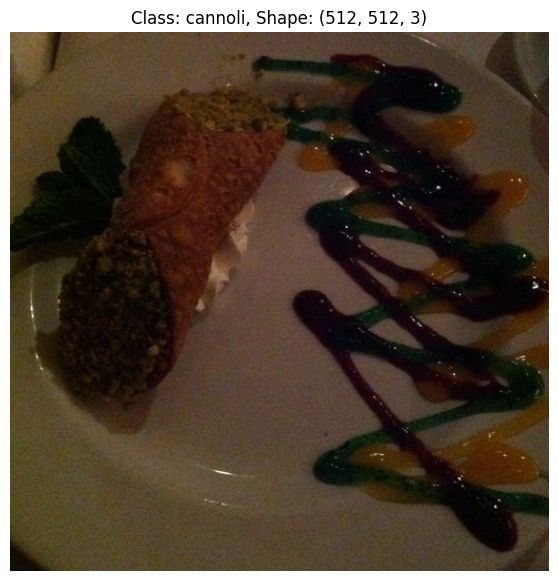

In [23]:
# konwersja obrazka do tablicy (sprowadzenie do liczb): tworzona jest lista wierszy (pojedyncze linijki pikseli obrazka). W każdej linijce znajdują się listy 3 elementowe reprezentujące RGB.
# ten etap jest konieczny ponieważ matplotlib przyjmuje tylko liczby
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Class: {image_class}, Shape: {img_as_array.shape}")
plt.axis(False)

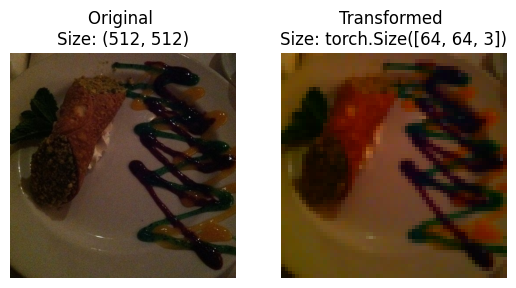

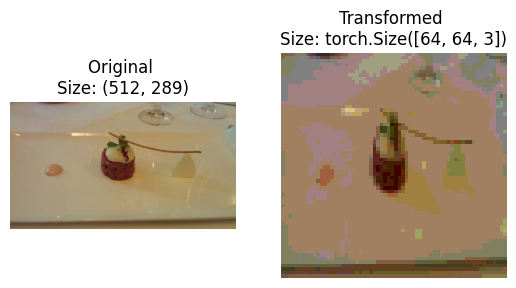

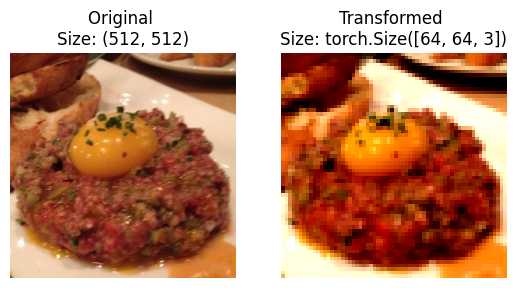

In [24]:
##### CHECKING #####

# wykonujemy dokładnie to samo co powyżej tylko w formie funkcji 
def plot_transformed_images(image_paths, transform, n=3, seed=None):  # przekazujemy image_path_list i będziemy losować tylko n z nich które wyświetlimy na wykresie. Przekażemy również transform który pozwoli nam zmniejszyć rozdzielczość i skonwertować dane do tensora
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)  # pobiera losową scieżkę do n obrazków
    for image_path in random_image_paths:  # iteracja po wylosowancych obrazkach
        with Image.open(image_path) as f:  # otworzenie obrazka jako f
            fig, ax = plt.subplots(nrows=1, ncols=2)  # 1 wykres 2 obrazki
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # transformowane obrazki
            transformed_image = transform(f).permute(1, 2, 0)  # wykonujemy to samo co w powyższej komórce z uzyskaniem odpowiedniej wymiarowości ponieważ matplotlib akceptuje (H, W, C) a nie (C, H, W - Pytorch)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

### Dataloader
num_workers określają nam liczbę subprocesów wykorzystywanych do wczytywania danych (data loading)
Czyli dzięki liczbie procesów większej niż 1 (zaczynamy od 0, gdzie 0 to tylko jeden subproces) otrzymujemy paralelizację przygotowywania batchy. Na przykład każdy subproces może obsługiwać jeden batch przygotowywany w tym samym momencie. CPU skupia się na przygotowywaniu danych kiedy GPU pracuje jedynie nad trenowaniem. Jeżeli CPU zarzuci GPU danymi wówczas to GPU będzie najsłabszym ogniwem spowalaniającym czas do wytrenowania modelu.

In [25]:
os.cpu_count()  # 32 wątki 16 rdzeni

32

In [26]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count()//4, shuffle=True)  # dobrą praktyką dla przyśpieszenia obliczeń jest korzystając z wątków CPU. Tutaj wykorzystamy tylko 8 (korzystamy z //4 by dzielić bez reszty w celu pozbycia się wartości po przecinku (8.0))

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count()//4, shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Budowanie modelu

In [27]:
class Food101(nn.Module):  # budowa na podstawie TinyVGG (patrz: https://poloclub.github.io/cnn-explainer/  - graf). Powszechną praktyką jest wykorzystywanie architektury bądź całych wytrenowanych modeli (stosując je do podobnych problemów w radzeniu sobie z którymi zostały zaprojektowane)
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),  # Patrz: https://poloclub.github.io/cnn-explainer/  - Understanding Hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),  # domyślnie stride ma taką samą wartość co kernel_size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # PRZYPOMNINIE: flatten "wypłaszcza" input ale nie modyfikuje hidden_units, dlatego trzebe to zrobić manualnie
            nn.Linear(in_features=hidden_units*16, out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
modelFood1 = Food101(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
  
modelFood1

Food101(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=4, bias=True)
  )
)

## Wykonanie modelu

In [28]:
img_batch, label_batch = next(iter(train_dataloader))
print(f"batch: {img_batch}, \nklasy w batch: {label_batch} ")

batch: tensor([[[[0.5647, 0.5020, 0.5020,  ..., 0.6275, 0.6275, 0.6275],
          [0.5647, 0.5647, 0.5647,  ..., 0.6275, 0.6902, 0.7529],
          [0.6275, 0.6275, 0.6275,  ..., 0.6275, 0.6275, 0.6902],
          ...,
          [0.4392, 0.5020, 0.5647,  ..., 0.5020, 0.5647, 0.5020],
          [0.2510, 0.3765, 0.5020,  ..., 0.5647, 0.5020, 0.3765],
          [0.0627, 0.2510, 0.3765,  ..., 0.5020, 0.3765, 0.2510]],

         [[0.5020, 0.4392, 0.4392,  ..., 0.3137, 0.5647, 0.5647],
          [0.5020, 0.5020, 0.5020,  ..., 0.2510, 0.4392, 0.6902],
          [0.5647, 0.5647, 0.5647,  ..., 0.2510, 0.1882, 0.4392],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0627, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3137, 0.2510, 0.2510,  ..., 0.1882, 0.4392, 0.5020],
          [0.3765, 0.3137, 0.3765,  ..., 0.0627, 0.3137, 0.6275],
          [0.3765, 0.3765, 0.3765, 

In [ ]:
# Artefakt - dostosowywania wymiarowości Linear po Flatten
"""
modelFood0(img_batch.to(device))


# 1) otrzymany error po powyższej linice kodu przy nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1690 and 2560x4)  -flatten zwraca 1 wiersz po 1690 kolumns,  linear zwraca 2560 wiersze po 4 kolumny, ponieważ hidden_units = 10 * 16 * 16 dla każedego z 4 klas czyli 2560x4. Jak pamiętamy macierze mogą się przemnożyć tylko wtedy gdy liczba kolumn pierwszej macierzy jest równa liczbie wierszy drugiej macierzy 1690 =/= 2560
# 2) Dzielimy liczbę kolumn pierwszej macierzy przez hidden_units i otrzymujemy wartość którą następnie musimy przemnożyć razy hidden_units by wymiarowości się zgadzały
# potrzebujemy 1690/10(liczba hidden_units)= 169 i wyciągnąć z niej pierwsiastek. Otrzymujemy 13
# 3) zmianiamy w class Food101:
# nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
# na 
# nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
"""

'\nmodelFood0(img_batch.to(device))\n\n\n# 1) otrzymany error po powyższej linice kodu przy nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)\n# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1690 and 2560x4)  -flatten zwraca 1 wiersz po 1690 kolumns,  linear zwraca 2560 wiersze po 4 kolumny, ponieważ hidden_units = 10 * 16 * 16 dla każedego z 4 klas czyli 2560x4. Jak pamiętamy macierze mogą się przemnożyć tylko wtedy gdy liczba kolumn pierwszej macierzy jest równa liczbie wierszy drugiej macierzy 1690 =/= 2560\n# 2) Dzielimy liczbę kolumn pierwszej macierzy przez hidden_units i otrzymujemy wartość którą następnie musimy przemnożyć razy hidden_units by wymiarowości się zgadzały\n# potrzebujemy 1690/10(liczba hidden_units)= 169 i wyciągnąć z niej pierwsiastek. Otrzymujemy 13\n# 3) zmianiamy w class Food101:\n# nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)\n# na \n# nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)\

In [29]:
##### CHECKING #####

# SPRAWDZENIE NA NIEWYTRENOWANYM MODELU - w celu sprawdzenia choćby czy wymiarowości się zgadzają czy nie są zwracane jakieś błędy

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]  # ponieważ podawane są jako input piksele chociaż predykcje obliczane są dla całych batchy, przewidziana klasa będzie wyświetlona dla każdego piksela z osobna. Możemy obejść to wypisując tylko pierwszą predykcję (skoro wszystkie i tak są takie same)
print(img_single.shape)  # img_single jest pierwszą wartością (1) w batchu, zawierającym trzy kolory RGB channels (3) i wymiary obrazka 64 na 64

modelFood1.eval()
with torch.inference_mode():
    pred_untrained = modelFood1(img_single.to(device))

print(f"Prawdopodobieństwa przewidziane dla batch[0]: {torch.softmax(pred_untrained, dim=1)}")
print(f"Wyciągnięta największa wartość indeksu klasy z prawdopodobieństw otrzymanych: {torch.argmax(torch.softmax(pred_untrained, dim=1), dim=1)}")  # może być całkowicie błędna (PRZYPOMNIENIE: jest to niewytrenowany model)
print(f"Prawdziwa klasa dla batcha[0]: {label_single}")  

torch.Size([1, 3, 64, 64])
Prawdopodobieństwa przewidziane dla batch[0]: tensor([[0.2252, 0.2723, 0.2556, 0.2469]], device='cuda:0')
Wyciągnięta największa wartość indeksu klasy z prawdopodobieństw otrzymanych: tensor([1], device='cuda:0')
Prawdziwa klasa dla batcha[0]: 2


In [30]:
#### CHECKING ####

# Podsumowanie modelu
print(summary(modelFood1, input_size=img_single.shape), '\n\n')

print(next(modelFood1.parameters()).dtype)  # domyślna skuteczność z jaką trenowany są modele pytorch

Layer (type:depth-idx)                   Output Shape              Param #
Food101                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [31]:
# Przesłanie do tensorboard. 
writer.add_graph(modelFood1, img_single.to(device))
writer.close()  # zamykanie writera powinno mieć miejsce tylko raz kiedy dodamy wszystko to co nas interesuje do tensorboard
# Jeżeli chcesz uruchomić tensorboard w terminalu (w odpowiednim folderze gdzie jest runs) wpisać w terminalu tensorboard --logdir=runs

### Trenowanie modelu

In [32]:
# Dobrą praktyką jest funkcjonalizacja pętli trenującej i testującej w projektach, ponieważ modularność:
# * ułatwia debuggowanie
# * implementację nowych operacji (np. regularyzacja, optymalizacja) przy bezpiecznej izolacji reszty kodu
# * skalowanie w przypadku większych projektów możemy w jednym nootbooku zawżeć kilka danych i modeli oraz wykorzystywać już zbudowane pętle trenujące

# Pętla trenująca:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = modelFood1(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # item() uzyskuje wartości skalarne z tensora. Uzyskane wyniki nie muszą być na GPU. Pozwoli to uniknąć błędów przy matplotlibie
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # kumulacyjne accuracy (przez wszystkie batche)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc /len(dataloader)
    return train_loss, train_acc

In [33]:
# Pętla testująca:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # kumulacyjne accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
# Funkcja wykonująca obie pętle

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,  # ponieważ pętla trenująca jak i testująca posiadają osobne dataloadery dlatego należy je różnie nazwać
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = NUM_EPOCHS):
    
    # zmienne na wyniki (z przyczyn wizualnych może to być słownik)
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []  
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,  # będą zwracane dwie wartości z funkcji train_step, więc przypisujemy je do dwóch zmiennych tak samo się nazwywających
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch} | train loss: {train_loss:.4f}, train acc: {100*train_acc:.2f}% | test loss: {test_loss:.4f}, test acc: {100*test_acc:.2f}%")
        
        # aktualizacja kumulacyjnego loss i acc po wyświetleniu rezultatów poprzedniej epoki
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [35]:
# Wykonanie trenowania
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1_results = train(model=modelFood1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=torch.optim.Adam(modelFood1.parameters(), lr=LEARNING_RATE),
                        loss_fn=nn.CrossEntropyLoss(),
                        epochs=NUM_EPOCHS)





  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.3886, train acc: 25.00% | test loss: 1.3889, test acc: 23.44%
Epoch: 1 | train loss: 1.3882, train acc: 25.00% | test loss: 1.3887, test acc: 23.44%
Epoch: 2 | train loss: 1.3879, train acc: 25.00% | test loss: 1.3883, test acc: 23.44%
Epoch: 3 | train loss: 1.3876, train acc: 25.00% | test loss: 1.3880, test acc: 23.44%
Epoch: 4 | train loss: 1.3875, train acc: 25.00% | test loss: 1.3878, test acc: 23.44%
Epoch: 5 | train loss: 1.3872, train acc: 25.00% | test loss: 1.3878, test acc: 23.44%
Epoch: 6 | train loss: 1.3871, train acc: 25.00% | test loss: 1.3873, test acc: 23.44%
Epoch: 7 | train loss: 1.3868, train acc: 25.00% | test loss: 1.3872, test acc: 23.44%
Epoch: 8 | train loss: 1.3867, train acc: 25.00% | test loss: 1.3869, test acc: 23.44%
Epoch: 9 | train loss: 1.3864, train acc: 25.42% | test loss: 1.3865, test acc: 27.34%
Epoch: 10 | train loss: 1.3865, train acc: 27.60% | test loss: 1.3863, test acc: 30.47%
Epoch: 11 | train loss: 1.3863, train acc:

## Sprawdzanie modelu/Wizualizacja predykcji

In [36]:
model_1_results

{'train_loss': [1.388615107536316,
  1.388150401910146,
  1.3879386504491171,
  1.3876257459322612,
  1.3874826788902284,
  1.3871549050013223,
  1.3871434529622395,
  1.3868318676948548,
  1.3866910656293234,
  1.3863892038663228,
  1.3864872137705484,
  1.386279825369517,
  1.3863300999005637,
  1.386079200108846,
  1.385949718952179,
  1.3857463439305624,
  1.3858233412106833,
  1.3850503166516621,
  1.3853794972101847,
  1.3851325750350951,
  1.3850997646649679,
  1.3841813762982687,
  1.3845525185267131,
  1.3830323060353598,
  1.3824205239613852,
  1.3796476324399312,
  1.3778649687767028,
  1.375164234638214,
  1.372103710969289,
  1.3653950015703837,
  1.3635891278584797,
  1.3527544697125753,
  1.3450000047683717,
  1.3449326515197755,
  1.3477035284042358,
  1.331618026892344,
  1.3277033766110737,
  1.3164661208788553,
  1.3144211848576863,
  1.3251319924990337,
  1.310507841904958,
  1.3070486267407735,
  1.2956675966580709,
  1.2871513366699219,
  1.2684903383255004,
  1.2

In [37]:
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [38]:
# Wykresy
def loss_curve(results):
    # Pobieranie loss z słowników obu pętli
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    # Pobieranie accuracy z słowników obu pętli
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    # Pobranie liczby epok
    epochs = range(len(results['train_loss']))
   
    plt.figure(figsize=(15, 7)) 
    
    # Wykres loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # wykres accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

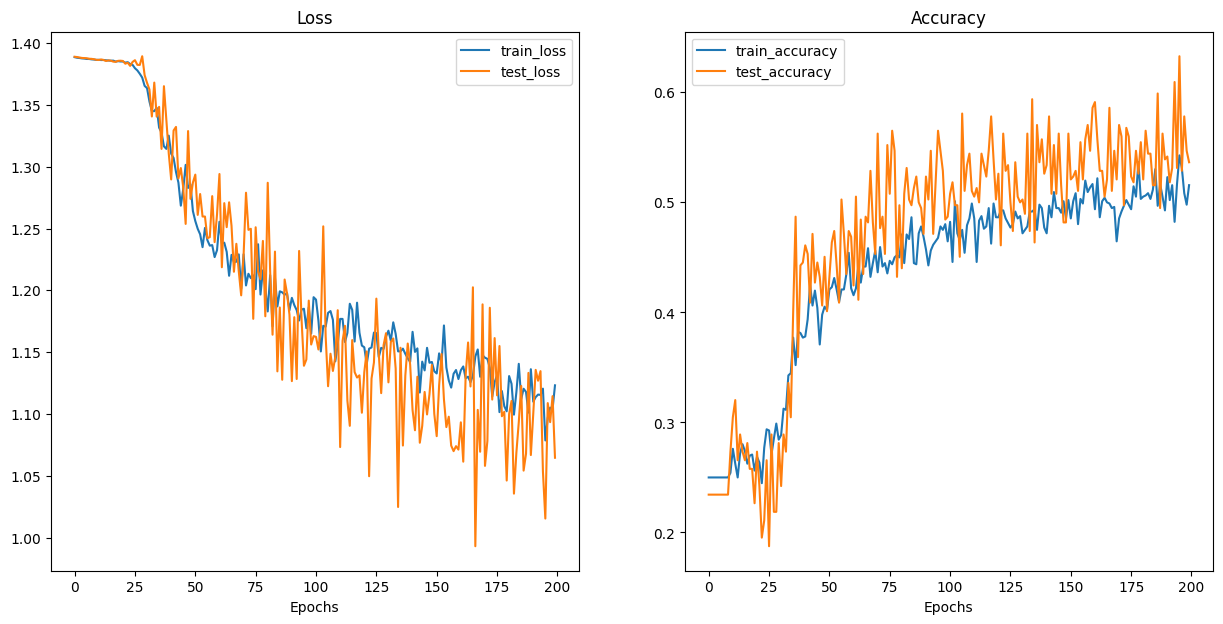

In [39]:
loss_curve(model_1_results)

Jeżeli train loss sukcesywnie spada ale test loss od pewnego momentu idze w góre oznacza overfitting (patrz rysunek interpretacja_wykresów.png)

Gdy mamy kilka modeli warto porównać je ze sobą, korzystając z jednego z poniższych:
* Tensorboard: służy do wizualizacji metryk, modelu (model graph), wag i basów jak się zmieniają w czasie, rzutowanie osadzeń na niższą przestrzeń wymiarową itp. ale również może służyć do śledzenia eksperymentów https://medium.com/@boluroajayia/experiment-tracking-with-tensorboard-using-pytorch-36f7edbdf81a
* Weihts & Biases - strona internetowa, narzędzie MLOps do śledzenia hiperparametrów różnych eksperymentów (zakładka Experiments) https://wandb.ai/site/experiment-tracking  (wybrać PYTORCH)
* MLFLOW - https://mlflow.org/docs/latest/tracking.html

Poniżej mamy przykładową implementację porównania dwóch modeli manualnie bez korzstania z powyższych frameworków MLOps:

In [42]:
# Architektura importowanego modelu (pobrana z Food-101_CNN-prototype.ipynb)
class Food101_0(nn.Module):  
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),  
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [43]:
modelFood0 = Food101_0(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_results = train(model=modelFood0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=torch.optim.Adam(modelFood1.parameters(), lr=LEARNING_RATE),
                        loss_fn=nn.CrossEntropyLoss(),
                        epochs=NUM_EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.0838, train acc: 52.50% | test loss: 1.3871, test acc: 22.66%
Epoch: 1 | train loss: 1.1091, train acc: 50.31% | test loss: 1.3870, test acc: 21.88%
Epoch: 2 | train loss: 1.1047, train acc: 54.90% | test loss: 1.3870, test acc: 23.44%
Epoch: 3 | train loss: 1.1153, train acc: 50.42% | test loss: 1.3869, test acc: 23.44%
Epoch: 4 | train loss: 1.0922, train acc: 51.35% | test loss: 1.3871, test acc: 23.44%
Epoch: 5 | train loss: 1.1018, train acc: 50.52% | test loss: 1.3870, test acc: 23.44%
Epoch: 6 | train loss: 1.0920, train acc: 50.83% | test loss: 1.3869, test acc: 24.22%
Epoch: 7 | train loss: 1.1057, train acc: 51.35% | test loss: 1.3870, test acc: 23.44%
Epoch: 8 | train loss: 1.0864, train acc: 53.54% | test loss: 1.3870, test acc: 23.44%
Epoch: 9 | train loss: 1.0573, train acc: 56.25% | test loss: 1.3869, test acc: 23.44%
Epoch: 10 | train loss: 1.0848, train acc: 52.81% | test loss: 1.3869, test acc: 23.44%
Epoch: 11 | train loss: 1.0799, train acc:

In [45]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.083819,0.525000,1.387076,0.226562
1,1.109120,0.503125,1.387010,0.218750
2,1.104730,0.548958,1.386972,0.234375
3,1.115284,0.504167,1.386934,0.234375
4,1.092180,0.513542,1.387111,0.234375
...,...,...,...,...
195,0.948945,0.597917,1.386941,0.226562
196,0.980409,0.594792,1.387036,0.234375
197,0.990543,0.576042,1.387081,0.234375
198,0.999079,0.593750,1.387020,0.242188


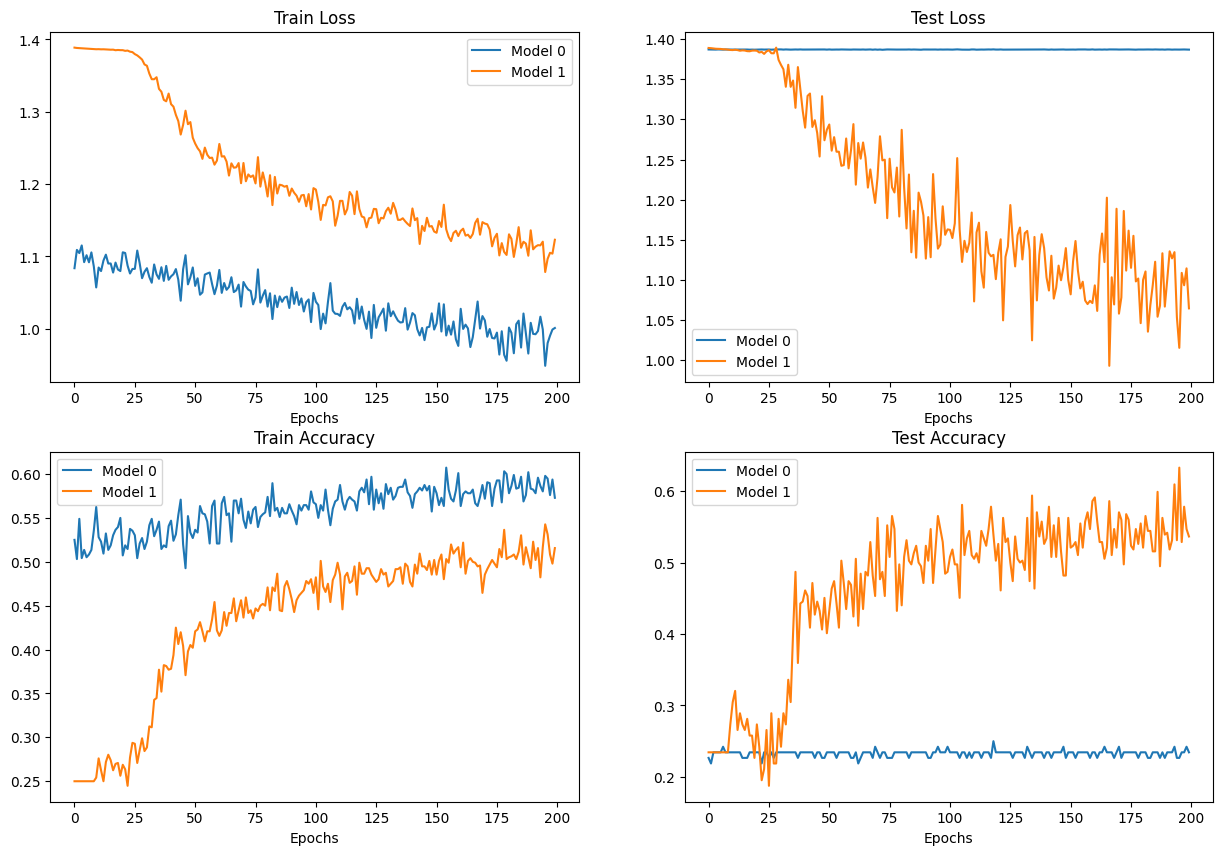

In [46]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

Wnioski: oba modele wypadły słabo

### Inference script

In [47]:
# Export to onnx
def export_to_onnx(model: torch.nn.Module, onnx_path: Path, opset: int = 17):
    model_cpu = model.to("cpu").eval()
    dummy = torch.randn(1, 3, 64, 64, dtype=torch.float32)

    onnx_path.parent.mkdir(parents=True, exist_ok=True)
    torch.onnx.export(
        model_cpu,
        dummy,
        str(onnx_path),
        input_names=["input"],
        output_names=["logits"],
        dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
        opset_version=opset
    )
    # sanity check
    m = onnx.load(str(onnx_path))
    onnx.checker.check_model(m)
    print(f"Exported ONNX to {onnx_path}")

In [48]:
path_to_onnx_model = Path.cwd().parent / "outputs/checkpoints/model_0.onnx"

In [49]:
export_to_onnx(model=modelFood1, onnx_path=path_to_onnx_model)

Exported ONNX to /home/kamil-solski/Documents/Python/Projekty_py/Food101_MLOps-Lvl_1/outputs/checkpoints/model_0.onnx


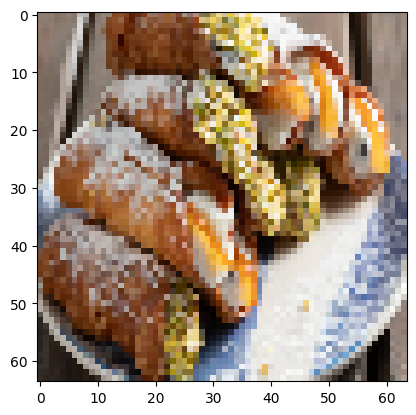

In [50]:
inference_image_path = Path.cwd().parent / "Data/cannoli.png"

# Read image as BGR and resize:
img = cv2.imread(inference_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)

plt.imshow(img)

In [51]:
# Convert to tensor: [H, W, C] → [C, H, W], then normalize to [0,1]
tensor_image = torch.from_numpy(img).permute(2, 0, 1).contiguous()  # [C, H, W], uint8
tensor_image = tensor_image.to(dtype=torch.float16) / 255.0
tensor_image = tensor_image.to(device)

print(f"custom image tensor: {tensor_image}")
print(f"custom image shape {tensor_image.shape}")
print(f"custom image datatype {tensor_image.dtype}")

custom image tensor: tensor([[[0.5605, 0.5605, 0.5649,  ..., 0.5884, 0.5649, 0.5923],
         [0.5527, 0.5527, 0.5488,  ..., 0.6157, 0.5488, 0.6001],
         [0.5649, 0.5410, 0.5649,  ..., 0.6313, 0.5371, 0.6118],
         ...,
         [0.2157, 0.2118, 0.1569,  ..., 0.5293, 0.5371, 0.7139],
         [0.1843, 0.1960, 0.1569,  ..., 0.5293, 0.5806, 0.6157],
         [0.1960, 0.1726, 0.1882,  ..., 0.3687, 0.5884, 0.6904]],

        [[0.4980, 0.4980, 0.4902,  ..., 0.5410, 0.5137, 0.5332],
         [0.4824, 0.4824, 0.4785,  ..., 0.5605, 0.5020, 0.5449],
         [0.4902, 0.4707, 0.4902,  ..., 0.5688, 0.4902, 0.5449],
         ...,
         [0.1921, 0.1882, 0.1255,  ..., 0.5059, 0.4902, 0.6392],
         [0.1726, 0.1530, 0.1255,  ..., 0.4980, 0.5410, 0.5332],
         [0.1726, 0.1412, 0.1412,  ..., 0.3647, 0.5488, 0.6196]],

        [[0.4470, 0.4470, 0.4353,  ..., 0.5059, 0.4785, 0.5020],
         [0.4275, 0.4353, 0.4158,  ..., 0.5137, 0.4626, 0.5020],
         [0.4353, 0.4119, 0.4353,  ..

In [52]:
def _softmax_np(x, axis=1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def pred_and_plot_image_onnx(
    onnx_model_path: Path,
    image_path: Path,
    class_names: list[str] | None = None,
    use_cuda: bool = True
):
    # Providers (CUDA if present)
    providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] if use_cuda else ["CPUExecutionProvider"]
    sess = ort.InferenceSession(str(onnx_model_path), providers=providers)

    # Preprocess
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image at {image_path}")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR)

    x = img.transpose(2, 0, 1).astype("float32") / 255.0  # [C,H,W] float32 in [0,1]
    x = np.expand_dims(x, axis=0)                          # [1,3,64,64]

    # Inference
    logits = sess.run(["logits"], {"input": x})[0]         # [1, num_classes]
    probs = _softmax_np(logits, axis=1)
    pred_idx = int(np.argmax(probs, axis=1)[0])
    pred_prob = float(probs[0, pred_idx])

    # Plot
    plt.imshow(img)
    title = f"Pred: {class_names[pred_idx]} | Prob: {pred_prob:.3f}" if class_names else f"Pred idx: {pred_idx} | Prob: {pred_prob:.3f}"
    plt.title(title)
    plt.axis(False)
    plt.show()

In [53]:
#load classes
with open(path_to_data / 'classes.txt', 'r') as f:
    class_names = [line.strip() for line in f]
    
print(type(class_names))

<class 'list'>


/home/kamil-solski/miniconda3/envs/Food101/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


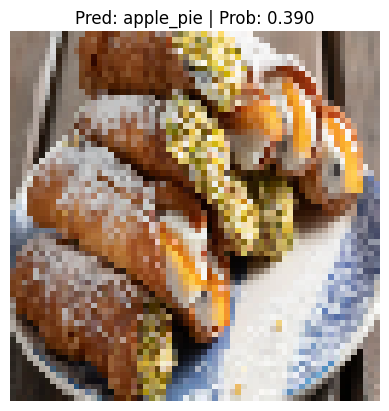

In [54]:
pred_and_plot_image_onnx(onnx_model_path=path_to_onnx_model, class_names=class_names, image_path=inference_image_path)